# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 14/07/2024</small></i></div>

Este notebook tiene como objetivo la definición de la última fase del modelo de difusión, es decir, el entrenamiento un modelo DDPM.

Para ello, este notebook se dividirá en las siguientes secciones:

- [0. Imports](#-0.-Imports)

- [1. Carga del dataset](#-1.-Carga-del-dataset)

- [2. Modelo](#-2.-Modelo)

  - [2.1. Entrenamiento](#21-entrenamiento)
  - [2.2 Evaluación del modelo](#22-evaluación-del-modelo)
  - [2.3 Guardado del modelo](#23-guardado-del-modelo)

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()``. Para implementar el training se ha usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido la funcionalidad extra que permiten guardar cada 100 epochs los pesos del modelo en un fichero con extensión `.weights.h5`. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo o para comparar la generación de muestras a lo largo del entrenamiento, entre otras cosas. Además, también se añade la posibilidad de, cada N epochs (siendo N un número determinado por el usuario), hacer una muestra donde se plotea el proceso de sampling desde $t = T$ hasta $t = 0$ y siempre partiendo desde el mismo ruido, todo ello, para ver como evoluciona el entrenamiento a lo largo de los epochs.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Este proceso de guardado se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde mas o menos se quedó sin problemas.
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
>
> Para más información: `src/model/model_callbacks`.
</small></i>

# 0. Imports

Una vez introducido el objetivo de este notebook, se importan las librerías necesarias para el desarrollo del apartado.

---

In [1]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-07-16 17:22:25.480209: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 17:22:25.509989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 17:22:26.720116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-16 17:22:26.723926: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Carga del dataset

En este apartado, se cargará el dataset que se usará para entrenar el modelo de difusión. En este caso, se usará el tf.data.Dataset creado en los notebooks anteriores. Pero con la ligera diferencia de que esta vez dividiremos dicho dataset en train y test para posteriormente al entreno del modelo evaluarlo usando el conjunto de test para garantizar el buen entrenamiento del modelo de difusión.

---

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

- The shape of the dataset is: (128, 32, 32, 3) => batch_size: 128, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


2024-07-16 17:22:28.145575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-07-16 17:22:28.323270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- Train size: 3840 sprites
- Test size: 128 sprites


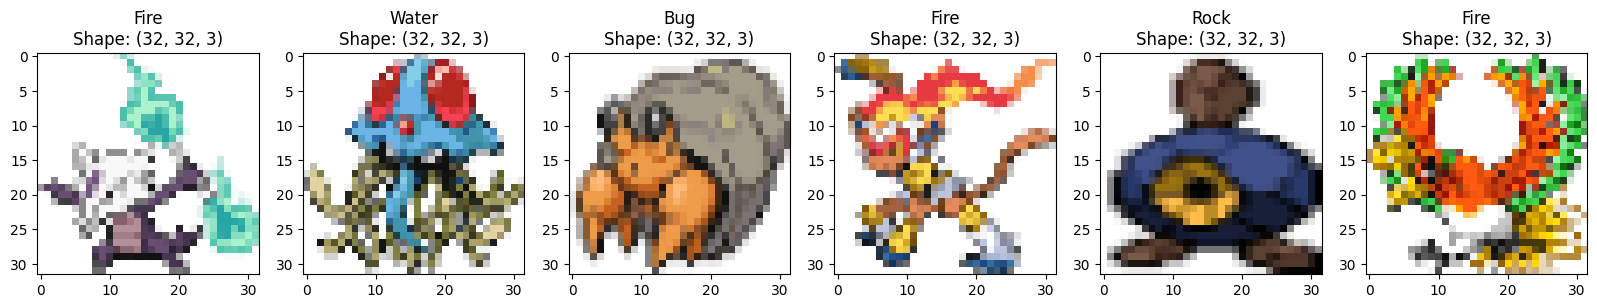

2024-07-16 17:22:29.189364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


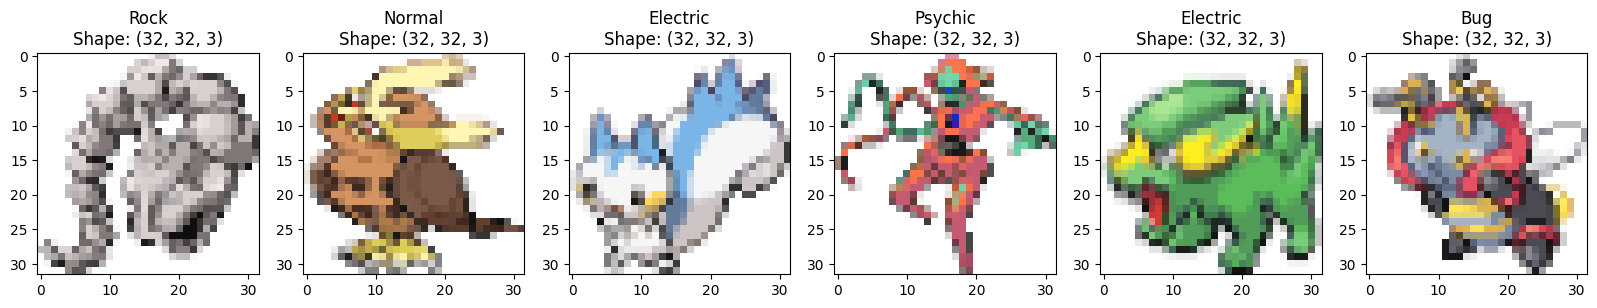

2024-07-16 17:22:29.547482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# train test split
# =====================================================================
train_poke_dataset, test_poke_dataset = tf.keras.utils.split_dataset(
    poke_dataset, left_size=0.96, shuffle=True
)

# Length of the datasets
print(f"- Train size: {len(train_poke_dataset) * BATCH_SIZE} sprites")
print(f"- Test size: {len(test_poke_dataset) * BATCH_SIZE} sprites")

# Plot
visualize.plot_images_batch(train_poke_dataset, 6)
visualize.plot_images_batch(test_poke_dataset, 6)

# 2. Modelo

Definimos el modelo usando la arquitectura **U-Net** y añadiendo las funcionalidades de un modelo de difusión con la clase `DiffusionModel()`. Además, se usa un modelo EMA (Exponential Moving Average) con el objetivo de mejorar el entrenamiento del modelo.

**Beneficios del EMA (Exponential Moving Average)**

1. **Estabilidad en la Predicción:** Las actualizaciones de los pesos de la red durante el entrenamiento pueden ser ruidosas y llevar a oscilaciones que afecten la estabilidad del modelo. Usar EMA de los pesos ayuda a suavizar estos cambios, resultando en una versión de los pesos que cambia más gradualmente y de manera más estable.

2. **Mejora en la Generalización:** Los pesos suavizados mediante EMA tienden a generalizar mejor en datos nuevos, lo que puede llevar a un mejor rendimiento en el conjunto de validación o de prueba. Esto se debe a que el EMA actúa como una forma de regularización, evitando que el modelo se ajuste demasiado a las fluctuaciones en el conjunto de datos de entrenamiento.

3. **Robustez ante el Ruido:** Al incorporar la historia de los pesos pasados de una manera suavizada, el EMA hace que la red sea menos sensible a actualizaciones ruidosas o gradientes espurios que pueden ocurrir durante el entrenamiento.

---

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES, dropout_rate=0.1)
ema_u_net = build_unet(
    IMG_SIZE, NUM_CLASSES, dropout_rate=0.1
)  # EMA model for smoother training
ema_u_net.set_weights(u_net.get_weights())  # Initialize EMA model with the same weights

model = DiffusionModel(
    model=u_net,
    ema_model=ema_u_net,
    img_size=IMG_SIZE,
    num_classes=NUM_CLASSES,
    timesteps=TIMESTEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    s=S,
    scheduler=SCHEDULER,
    ema=0.999,
)

# Compile the model
# =====================================================================
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

## 2.1. Entrenamiento

Entrenamos el modelo con los `EPOCHS` definido como hiperparámetro en el `config.ini` y añadimos la funcionalidad de guardado y muestreo de imágenes durante el entrenamiento a través del callback `DiffusionCallback`.

Epoch 1/4000


/home/pqlza/.local/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma'

 1/30 ━━━━━━━━━━━━━━━━━━━━ 28:16 58s/step - mae: 1.1101 - loss: 1.9516

I0000 00:00:1720949364.033365  218447 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1720949364.067697  218447 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - mae: 1.0452 - loss: 1.7327

I0000 00:00:1720949369.617534  219602 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 172 bytes spill stores, 172 bytes spill loads



30/30 ━━━━━━━━━━━━━━━━━━━━ 66s 261ms/step - mae: 1.0437 - loss: 1.7279 - val_loss: 1.2617 - val_mae: 0.8944
Epoch 2/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.9030 - loss: 1.2869 - val_loss: 1.0869 - val_mae: 0.8306
Epoch 3/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.8400 - loss: 1.1126 - val_loss: 0.9919 - val_mae: 0.7936
Epoch 4/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.8008 - loss: 1.0112 - val_loss: 0.9304 - val_mae: 0.7689
Epoch 5/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.7766 - loss: 0.9511 - val_loss: 0.8932 - val_mae: 0.7534
Epoch 6/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.7562 - loss: 0.9021 - val_loss: 0.8458 - val_mae: 0.7327
Epoch 7/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.7404 - loss: 0.8659 - val_loss: 0.8347 - val_mae: 0.7265
Epoch 8/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.7238 - loss: 0.8290 - val_loss: 0.8010 - val_mae: 0.7111
Epoch 9/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/ste

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.68it/s]


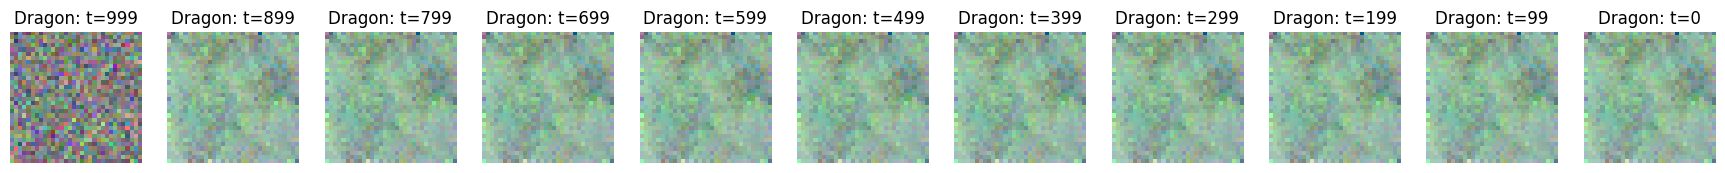

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.3246 - loss: 0.2112 - val_loss: 0.2087 - val_mae: 0.3181
Epoch 101/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3261 - loss: 0.2138 - val_loss: 0.2006 - val_mae: 0.3137
Epoch 102/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3274 - loss: 0.2159 - val_loss: 0.2024 - val_mae: 0.3164
Epoch 103/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3232 - loss: 0.2094 - val_loss: 0.2310 - val_mae: 0.3363
Epoch 104/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3243 - loss: 0.2124 - val_loss: 0.2042 - val_mae: 0.3209
Epoch 105/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3263 - loss: 0.2155 - val_loss: 0.2039 - val_mae: 0.3216
Epoch 106/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.3194 - loss: 0.2052 - val_loss: 0.2264 - val_mae: 0.3303
Epoch 107/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.3192 - loss: 0.2080 - val_loss: 0.1992 - val_mae: 0.3140
Epoch 108/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:31<00:00, 10.96it/s]


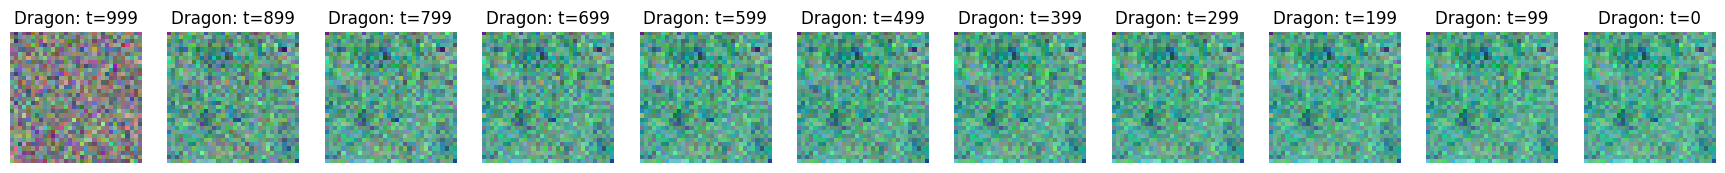

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.2718 - loss: 0.1648 - val_loss: 0.1561 - val_mae: 0.2647
Epoch 201/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2674 - loss: 0.1624 - val_loss: 0.1354 - val_mae: 0.2428
Epoch 202/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2667 - loss: 0.1597 - val_loss: 0.1584 - val_mae: 0.2586
Epoch 203/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2637 - loss: 0.1562 - val_loss: 0.1378 - val_mae: 0.2465
Epoch 204/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2660 - loss: 0.1596 - val_loss: 0.1747 - val_mae: 0.2709
Epoch 205/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2666 - loss: 0.1591 - val_loss: 0.1369 - val_mae: 0.2472
Epoch 206/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2648 - loss: 0.1580 - val_loss: 0.1427 - val_mae: 0.2456
Epoch 207/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2676 - loss: 0.1627 - val_loss: 0.1653 - val_mae: 0.2667
Epoch 208/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.75it/s]


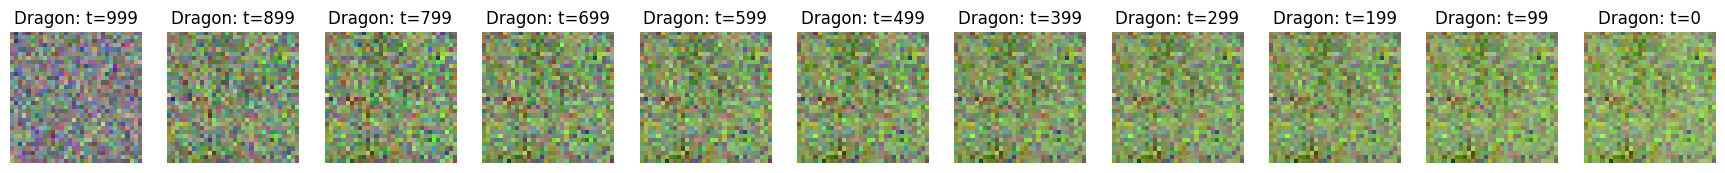

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.2386 - loss: 0.1373 - val_loss: 0.1436 - val_mae: 0.2425
Epoch 301/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2405 - loss: 0.1398 - val_loss: 0.1564 - val_mae: 0.2528
Epoch 302/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2401 - loss: 0.1397 - val_loss: 0.1282 - val_mae: 0.2314
Epoch 303/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2344 - loss: 0.1325 - val_loss: 0.1319 - val_mae: 0.2341
Epoch 304/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2349 - loss: 0.1329 - val_loss: 0.1063 - val_mae: 0.2042
Epoch 305/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2372 - loss: 0.1354 - val_loss: 0.1223 - val_mae: 0.2218
Epoch 306/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2407 - loss: 0.1410 - val_loss: 0.1366 - val_mae: 0.2369
Epoch 307/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2401 - loss: 0.1389 - val_loss: 0.1315 - val_mae: 0.2323
Epoch 308/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.55it/s]


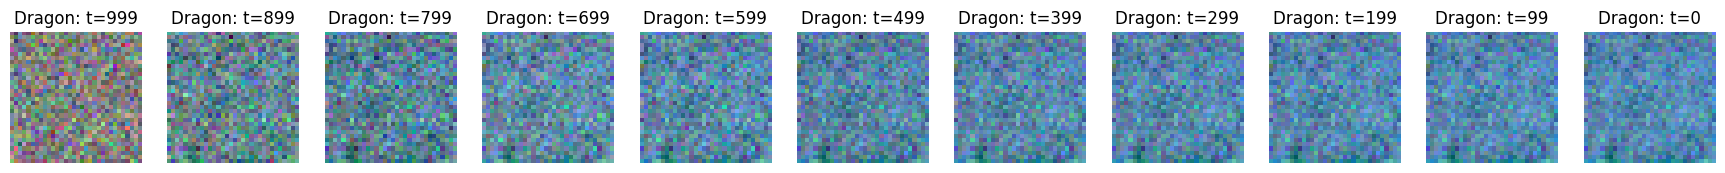

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.2247 - loss: 0.1260 - val_loss: 0.1261 - val_mae: 0.2251
Epoch 401/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2253 - loss: 0.1268 - val_loss: 0.1133 - val_mae: 0.2093
Epoch 402/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2322 - loss: 0.1361 - val_loss: 0.1076 - val_mae: 0.2052
Epoch 403/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2276 - loss: 0.1290 - val_loss: 0.1085 - val_mae: 0.2062
Epoch 404/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2270 - loss: 0.1297 - val_loss: 0.1239 - val_mae: 0.2198
Epoch 405/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2251 - loss: 0.1280 - val_loss: 0.1250 - val_mae: 0.2207
Epoch 406/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2268 - loss: 0.1289 - val_loss: 0.1199 - val_mae: 0.2158
Epoch 407/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2231 - loss: 0.1248 - val_loss: 0.1149 - val_mae: 0.2169
Epoch 408/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.61it/s]


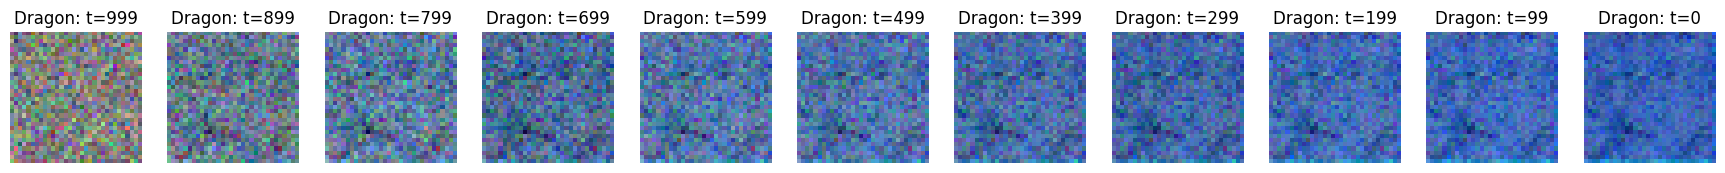

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.2236 - loss: 0.1282 - val_loss: 0.1269 - val_mae: 0.2158
Epoch 501/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2177 - loss: 0.1219 - val_loss: 0.1264 - val_mae: 0.2204
Epoch 502/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2169 - loss: 0.1203 - val_loss: 0.1318 - val_mae: 0.2215
Epoch 503/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2229 - loss: 0.1284 - val_loss: 0.1301 - val_mae: 0.2197
Epoch 504/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2197 - loss: 0.1229 - val_loss: 0.1205 - val_mae: 0.2125
Epoch 505/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2169 - loss: 0.1217 - val_loss: 0.1141 - val_mae: 0.2131
Epoch 506/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2218 - loss: 0.1275 - val_loss: 0.1030 - val_mae: 0.2007
Epoch 507/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2153 - loss: 0.1191 - val_loss: 0.1322 - val_mae: 0.2258
Epoch 508/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.76it/s]


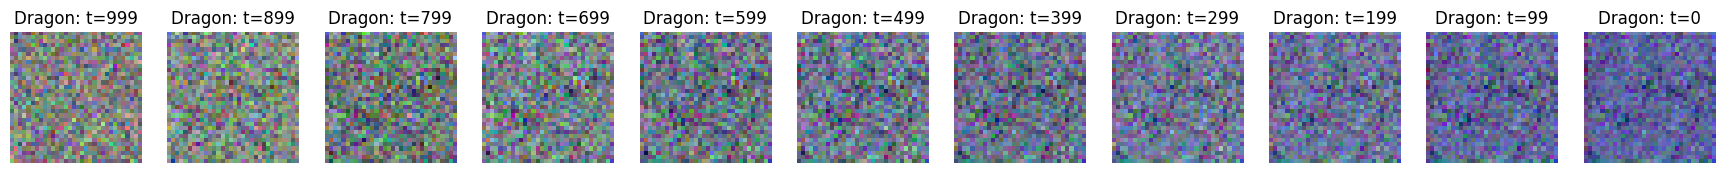

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.2127 - loss: 0.1185 - val_loss: 0.1126 - val_mae: 0.2047
Epoch 601/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2183 - loss: 0.1247 - val_loss: 0.1241 - val_mae: 0.2136
Epoch 602/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2106 - loss: 0.1166 - val_loss: 0.1320 - val_mae: 0.2213
Epoch 603/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2100 - loss: 0.1163 - val_loss: 0.1092 - val_mae: 0.2006
Epoch 604/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2114 - loss: 0.1169 - val_loss: 0.1252 - val_mae: 0.2154
Epoch 605/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2116 - loss: 0.1169 - val_loss: 0.1108 - val_mae: 0.2065
Epoch 606/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2075 - loss: 0.1127 - val_loss: 0.1243 - val_mae: 0.2078
Epoch 607/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2160 - loss: 0.1223 - val_loss: 0.1136 - val_mae: 0.2074
Epoch 608/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.72it/s]


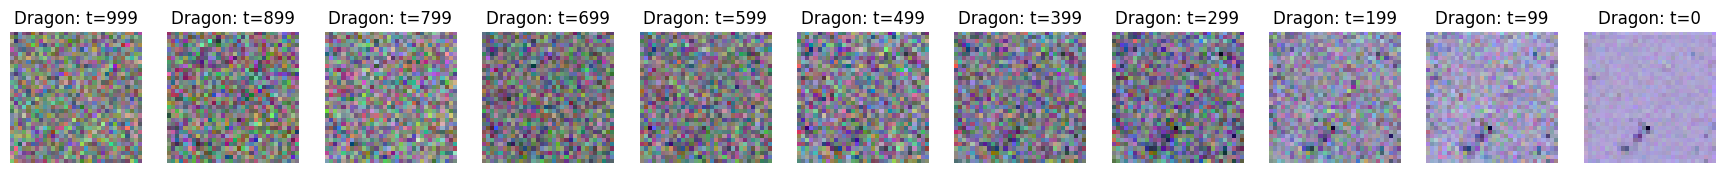

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.2105 - loss: 0.1185 - val_loss: 0.1116 - val_mae: 0.2036
Epoch 701/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2106 - loss: 0.1182 - val_loss: 0.1144 - val_mae: 0.2040
Epoch 702/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2092 - loss: 0.1158 - val_loss: 0.0984 - val_mae: 0.1935
Epoch 703/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2069 - loss: 0.1152 - val_loss: 0.1080 - val_mae: 0.1998
Epoch 704/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2117 - loss: 0.1190 - val_loss: 0.1221 - val_mae: 0.2122
Epoch 705/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2088 - loss: 0.1160 - val_loss: 0.1165 - val_mae: 0.2099
Epoch 706/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2060 - loss: 0.1129 - val_loss: 0.1204 - val_mae: 0.2107
Epoch 707/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2080 - loss: 0.1151 - val_loss: 0.1344 - val_mae: 0.2172
Epoch 708/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.56it/s]


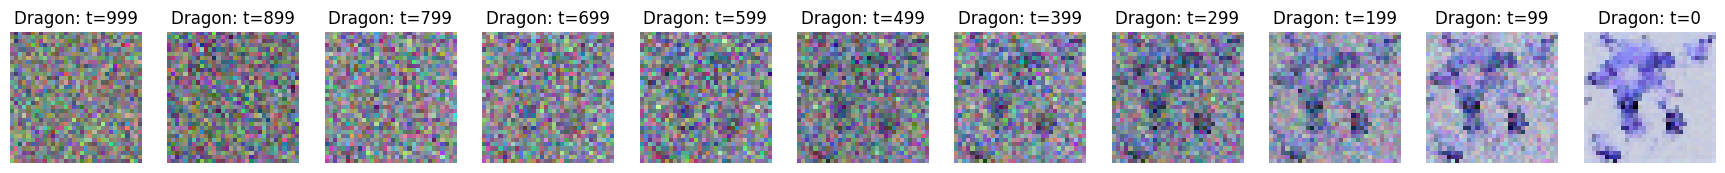

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.2076 - loss: 0.1159 - val_loss: 0.1133 - val_mae: 0.1994
Epoch 801/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2075 - loss: 0.1167 - val_loss: 0.1144 - val_mae: 0.2053
Epoch 802/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2039 - loss: 0.1113 - val_loss: 0.1136 - val_mae: 0.2022
Epoch 803/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2051 - loss: 0.1135 - val_loss: 0.1011 - val_mae: 0.1943
Epoch 804/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2048 - loss: 0.1137 - val_loss: 0.1048 - val_mae: 0.1918
Epoch 805/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2044 - loss: 0.1121 - val_loss: 0.1159 - val_mae: 0.2047
Epoch 806/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2019 - loss: 0.1104 - val_loss: 0.1315 - val_mae: 0.2212
Epoch 807/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2012 - loss: 0.1095 - val_loss: 0.0949 - val_mae: 0.1862
Epoch 808/4000
30/30 ━━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.41it/s]


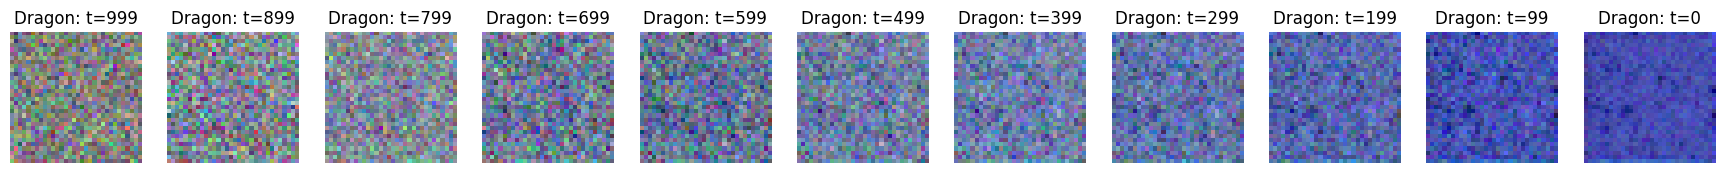

30/30 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - mae: 0.2040 - loss: 0.1128 - val_loss: 0.1088 - val_mae: 0.1963
Epoch 901/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2024 - loss: 0.1118 - val_loss: 0.1174 - val_mae: 0.2032
Epoch 902/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2032 - loss: 0.1127 - val_loss: 0.1071 - val_mae: 0.1980
Epoch 903/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2063 - loss: 0.1158 - val_loss: 0.1065 - val_mae: 0.1958
Epoch 904/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - mae: 0.2052 - loss: 0.1154 - val_loss: 0.1160 - val_mae: 0.2029
Epoch 905/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2019 - loss: 0.1124 - val_loss: 0.1188 - val_mae: 0.2066
Epoch 906/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2015 - loss: 0.1113 - val_loss: 0.1102 - val_mae: 0.2038
Epoch 907/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2019 - loss: 0.1111 - val_loss: 0.1050 - val_mae: 0.1937
Epoch 908/4000
30/30 ━━━━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.70it/s]


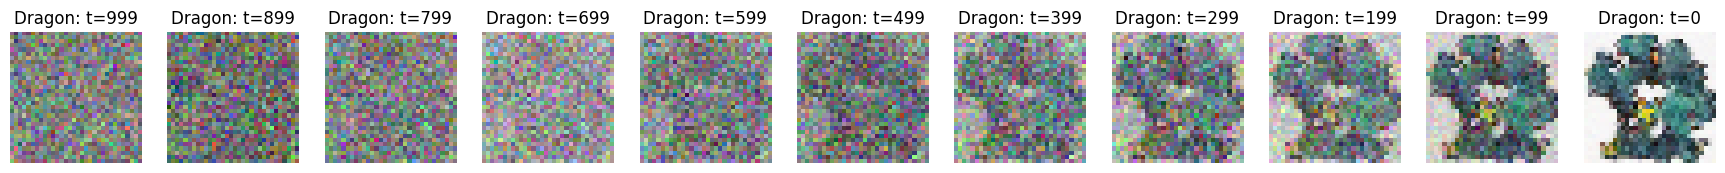

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.2039 - loss: 0.1137 - val_loss: 0.1141 - val_mae: 0.1977
Epoch 1001/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2037 - loss: 0.1137 - val_loss: 0.1174 - val_mae: 0.2042
Epoch 1002/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1980 - loss: 0.1080 - val_loss: 0.1067 - val_mae: 0.1967
Epoch 1003/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2009 - loss: 0.1108 - val_loss: 0.1068 - val_mae: 0.1936
Epoch 1004/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2015 - loss: 0.1131 - val_loss: 0.1027 - val_mae: 0.1901
Epoch 1005/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2073 - loss: 0.1180 - val_loss: 0.1104 - val_mae: 0.1967
Epoch 1006/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2019 - loss: 0.1121 - val_loss: 0.1255 - val_mae: 0.2119
Epoch 1007/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2020 - loss: 0.1121 - val_loss: 0.0935 - val_mae: 0.1846
Epoch 1008/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.74it/s]


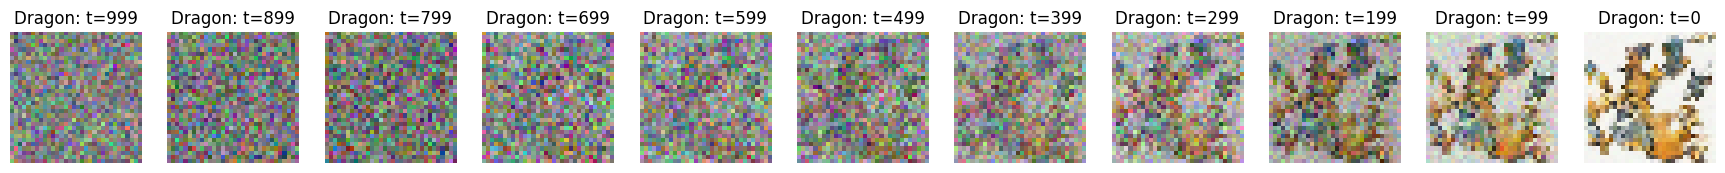

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.1996 - loss: 0.1112 - val_loss: 0.1097 - val_mae: 0.1957
Epoch 1101/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1953 - loss: 0.1066 - val_loss: 0.1126 - val_mae: 0.1988
Epoch 1102/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1982 - loss: 0.1092 - val_loss: 0.1209 - val_mae: 0.2043
Epoch 1103/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1995 - loss: 0.1098 - val_loss: 0.0980 - val_mae: 0.1863
Epoch 1104/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.2036 - loss: 0.1148 - val_loss: 0.1005 - val_mae: 0.1847
Epoch 1105/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1968 - loss: 0.1078 - val_loss: 0.1001 - val_mae: 0.1894
Epoch 1106/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1993 - loss: 0.1087 - val_loss: 0.0961 - val_mae: 0.1857
Epoch 1107/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1973 - loss: 0.1084 - val_loss: 0.1012 - val_mae: 0.1951
Epoch 1108/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.57it/s]


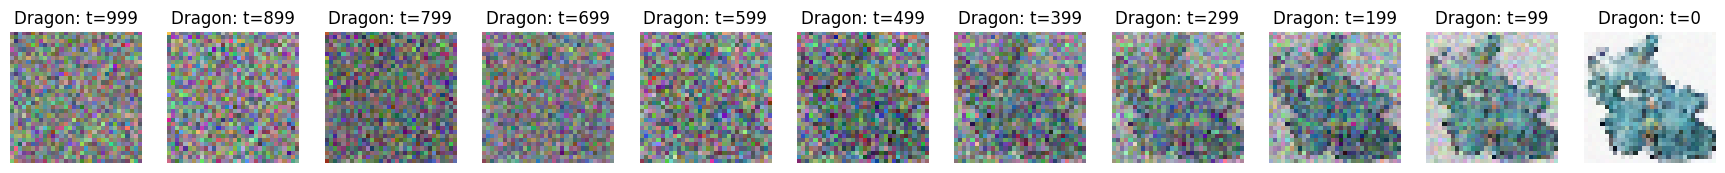

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1960 - loss: 0.1077 - val_loss: 0.1002 - val_mae: 0.1921
Epoch 1201/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1935 - loss: 0.1047 - val_loss: 0.1222 - val_mae: 0.2061
Epoch 1202/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1947 - loss: 0.1059 - val_loss: 0.1039 - val_mae: 0.1894
Epoch 1203/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.2010 - loss: 0.1129 - val_loss: 0.1239 - val_mae: 0.2072
Epoch 1204/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1970 - loss: 0.1084 - val_loss: 0.1118 - val_mae: 0.1984
Epoch 1205/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1986 - loss: 0.1094 - val_loss: 0.1102 - val_mae: 0.1921
Epoch 1206/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1973 - loss: 0.1095 - val_loss: 0.1224 - val_mae: 0.2080
Epoch 1207/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1964 - loss: 0.1072 - val_loss: 0.0992 - val_mae: 0.1842
Epoch 1208/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.52it/s]


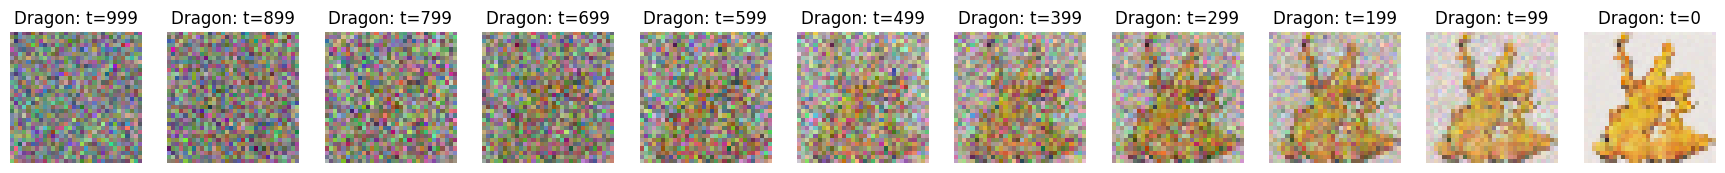

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1935 - loss: 0.1055 - val_loss: 0.1057 - val_mae: 0.1891
Epoch 1301/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1956 - loss: 0.1076 - val_loss: 0.1200 - val_mae: 0.2026
Epoch 1302/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1943 - loss: 0.1050 - val_loss: 0.1336 - val_mae: 0.2168
Epoch 1303/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1937 - loss: 0.1053 - val_loss: 0.1020 - val_mae: 0.1890
Epoch 1304/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1976 - loss: 0.1098 - val_loss: 0.0919 - val_mae: 0.1808
Epoch 1305/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1956 - loss: 0.1067 - val_loss: 0.0959 - val_mae: 0.1827
Epoch 1306/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1953 - loss: 0.1059 - val_loss: 0.1140 - val_mae: 0.1997
Epoch 1307/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1950 - loss: 0.1070 - val_loss: 0.1081 - val_mae: 0.1951
Epoch 1308/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.74it/s]


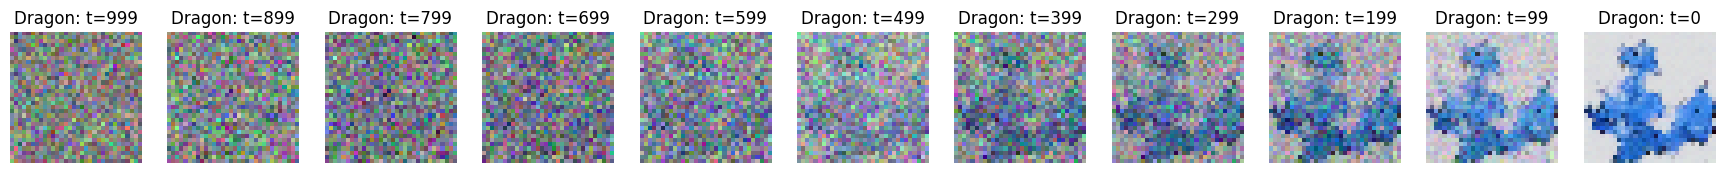

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.1970 - loss: 0.1108 - val_loss: 0.1025 - val_mae: 0.1839
Epoch 1401/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1929 - loss: 0.1050 - val_loss: 0.1120 - val_mae: 0.1967
Epoch 1402/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1931 - loss: 0.1066 - val_loss: 0.1208 - val_mae: 0.2026
Epoch 1403/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1931 - loss: 0.1059 - val_loss: 0.1138 - val_mae: 0.1958
Epoch 1404/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1936 - loss: 0.1062 - val_loss: 0.1174 - val_mae: 0.2034
Epoch 1405/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1893 - loss: 0.1012 - val_loss: 0.0948 - val_mae: 0.1832
Epoch 1406/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1936 - loss: 0.1069 - val_loss: 0.1078 - val_mae: 0.1968
Epoch 1407/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1941 - loss: 0.1066 - val_loss: 0.1052 - val_mae: 0.1916
Epoch 1408/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.66it/s]


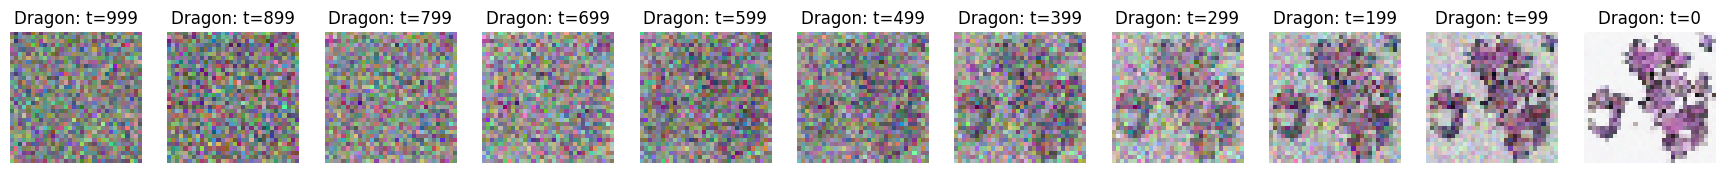

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.1919 - loss: 0.1050 - val_loss: 0.1113 - val_mae: 0.1966
Epoch 1501/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1919 - loss: 0.1058 - val_loss: 0.1081 - val_mae: 0.1917
Epoch 1502/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1911 - loss: 0.1027 - val_loss: 0.1057 - val_mae: 0.1903
Epoch 1503/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1921 - loss: 0.1053 - val_loss: 0.1163 - val_mae: 0.2055
Epoch 1504/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1918 - loss: 0.1046 - val_loss: 0.0940 - val_mae: 0.1818
Epoch 1505/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1911 - loss: 0.1030 - val_loss: 0.0908 - val_mae: 0.1773
Epoch 1506/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1903 - loss: 0.1029 - val_loss: 0.0924 - val_mae: 0.1806
Epoch 1507/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1933 - loss: 0.1055 - val_loss: 0.1043 - val_mae: 0.1895
Epoch 1508/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.62it/s]


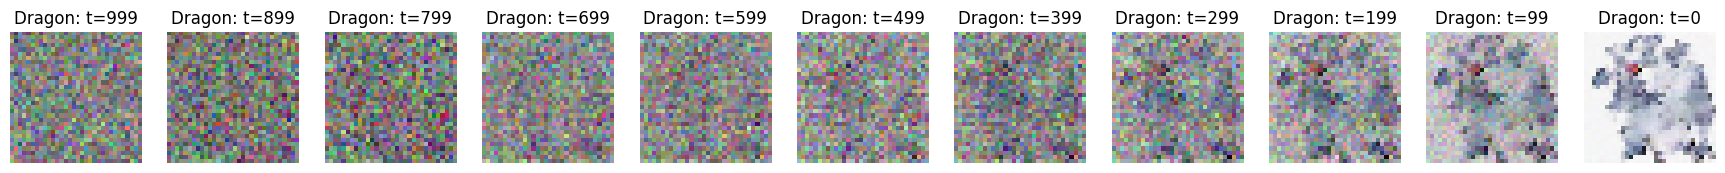

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1869 - loss: 0.1003 - val_loss: 0.1027 - val_mae: 0.1864
Epoch 1601/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1935 - loss: 0.1064 - val_loss: 0.1025 - val_mae: 0.1897
Epoch 1602/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1941 - loss: 0.1071 - val_loss: 0.0878 - val_mae: 0.1744
Epoch 1603/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1903 - loss: 0.1041 - val_loss: 0.1028 - val_mae: 0.1881
Epoch 1604/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1893 - loss: 0.1032 - val_loss: 0.1008 - val_mae: 0.1839
Epoch 1605/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1893 - loss: 0.1025 - val_loss: 0.1003 - val_mae: 0.1877
Epoch 1606/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1907 - loss: 0.1039 - val_loss: 0.1079 - val_mae: 0.1947
Epoch 1607/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1899 - loss: 0.1023 - val_loss: 0.1071 - val_mae: 0.1905
Epoch 1608/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.74it/s]


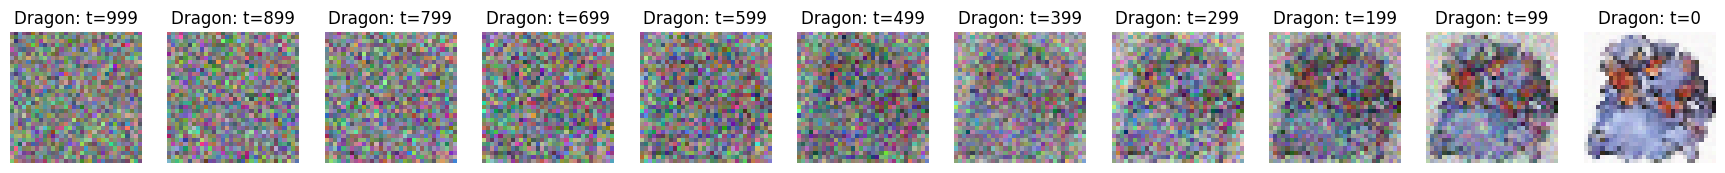

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.1896 - loss: 0.1031 - val_loss: 0.0968 - val_mae: 0.1829
Epoch 1701/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1896 - loss: 0.1032 - val_loss: 0.1132 - val_mae: 0.1990
Epoch 1702/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1922 - loss: 0.1059 - val_loss: 0.1119 - val_mae: 0.1950
Epoch 1703/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1887 - loss: 0.1026 - val_loss: 0.1065 - val_mae: 0.1931
Epoch 1704/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1885 - loss: 0.1022 - val_loss: 0.1123 - val_mae: 0.1958
Epoch 1705/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1886 - loss: 0.1020 - val_loss: 0.1164 - val_mae: 0.1996
Epoch 1706/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1900 - loss: 0.1027 - val_loss: 0.0973 - val_mae: 0.1815
Epoch 1707/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1899 - loss: 0.1022 - val_loss: 0.1066 - val_mae: 0.1941
Epoch 1708/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.45it/s]


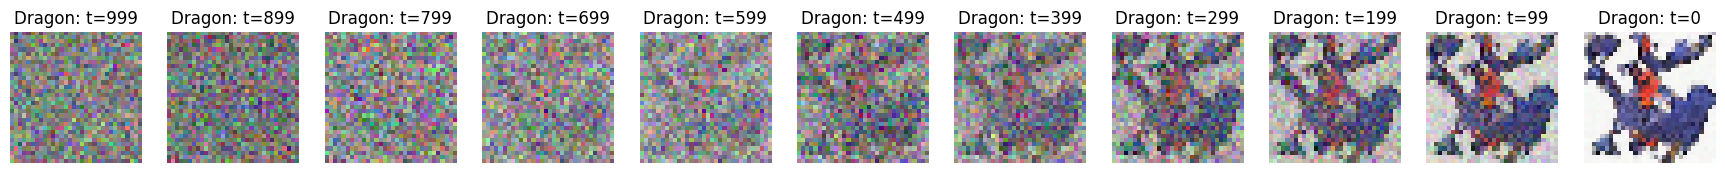

30/30 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - mae: 0.1919 - loss: 0.1058 - val_loss: 0.0971 - val_mae: 0.1831
Epoch 1801/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1895 - loss: 0.1043 - val_loss: 0.1019 - val_mae: 0.1883
Epoch 1802/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1868 - loss: 0.0994 - val_loss: 0.1103 - val_mae: 0.1944
Epoch 1803/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1921 - loss: 0.1064 - val_loss: 0.0846 - val_mae: 0.1736
Epoch 1804/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1884 - loss: 0.1027 - val_loss: 0.0980 - val_mae: 0.1854
Epoch 1805/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1908 - loss: 0.1046 - val_loss: 0.1042 - val_mae: 0.1875
Epoch 1806/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1889 - loss: 0.1016 - val_loss: 0.1112 - val_mae: 0.1990
Epoch 1807/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1893 - loss: 0.1027 - val_loss: 0.1052 - val_mae: 0.1888
Epoch 1808/4000
30/30 ━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.46it/s]


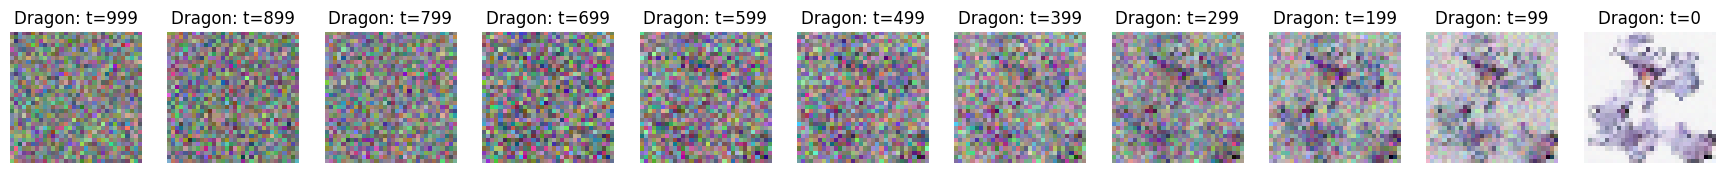

30/30 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - mae: 0.1882 - loss: 0.1021 - val_loss: 0.1098 - val_mae: 0.1930
Epoch 1901/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1853 - loss: 0.1000 - val_loss: 0.1044 - val_mae: 0.1887
Epoch 1902/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1893 - loss: 0.1033 - val_loss: 0.0861 - val_mae: 0.1725
Epoch 1903/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1869 - loss: 0.1010 - val_loss: 0.1044 - val_mae: 0.1847
Epoch 1904/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1900 - loss: 0.1034 - val_loss: 0.0804 - val_mae: 0.1668
Epoch 1905/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1850 - loss: 0.0986 - val_loss: 0.1043 - val_mae: 0.1896
Epoch 1906/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1884 - loss: 0.1035 - val_loss: 0.1026 - val_mae: 0.1916
Epoch 1907/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1877 - loss: 0.1022 - val_loss: 0.1331 - val_mae: 0.2166
Epoch 1908/4000
30/30 ━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.48it/s]


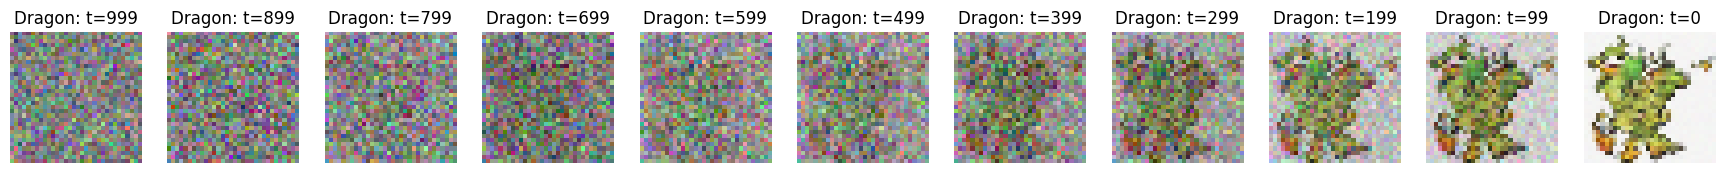

30/30 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - mae: 0.1856 - loss: 0.1001 - val_loss: 0.0913 - val_mae: 0.1729
Epoch 2001/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1888 - loss: 0.1032 - val_loss: 0.1040 - val_mae: 0.1882
Epoch 2002/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1859 - loss: 0.0991 - val_loss: 0.0930 - val_mae: 0.1762
Epoch 2003/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1889 - loss: 0.1043 - val_loss: 0.1114 - val_mae: 0.1912
Epoch 2004/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1834 - loss: 0.0991 - val_loss: 0.0920 - val_mae: 0.1700
Epoch 2005/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1876 - loss: 0.1021 - val_loss: 0.0958 - val_mae: 0.1788
Epoch 2006/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1879 - loss: 0.1017 - val_loss: 0.0998 - val_mae: 0.1850
Epoch 2007/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1852 - loss: 0.0986 - val_loss: 0.1107 - val_mae: 0.1955
Epoch 2008/4000
30/30 ━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:35<00:00, 10.48it/s]


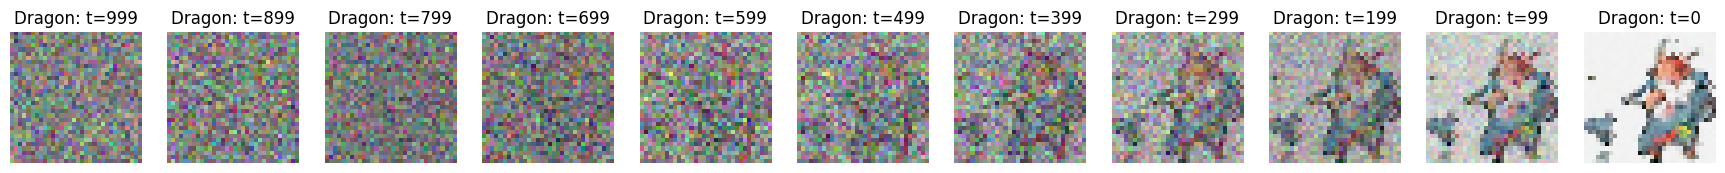

30/30 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - mae: 0.1839 - loss: 0.0981 - val_loss: 0.1060 - val_mae: 0.1857
Epoch 2101/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1880 - loss: 0.1017 - val_loss: 0.0958 - val_mae: 0.1760
Epoch 2102/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1833 - loss: 0.0977 - val_loss: 0.1128 - val_mae: 0.1943
Epoch 2103/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1834 - loss: 0.0985 - val_loss: 0.1124 - val_mae: 0.1930
Epoch 2104/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1881 - loss: 0.1022 - val_loss: 0.0991 - val_mae: 0.1812
Epoch 2105/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1901 - loss: 0.1056 - val_loss: 0.0979 - val_mae: 0.1804
Epoch 2106/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1901 - loss: 0.1048 - val_loss: 0.1086 - val_mae: 0.1955
Epoch 2107/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1835 - loss: 0.0983 - val_loss: 0.0963 - val_mae: 0.1775
Epoch 2108/4000
30/30 ━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:31<00:00, 10.92it/s]


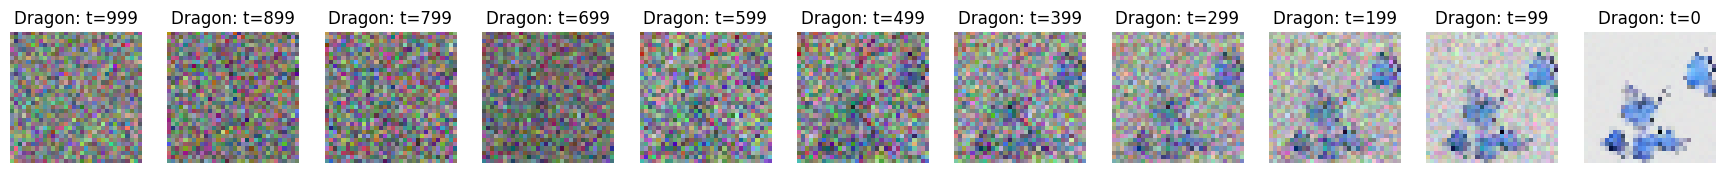

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.1831 - loss: 0.0985 - val_loss: 0.0835 - val_mae: 0.1718
Epoch 2201/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1841 - loss: 0.0998 - val_loss: 0.1036 - val_mae: 0.1875
Epoch 2202/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1891 - loss: 0.1041 - val_loss: 0.1030 - val_mae: 0.1866
Epoch 2203/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1881 - loss: 0.1021 - val_loss: 0.1000 - val_mae: 0.1810
Epoch 2204/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1841 - loss: 0.0990 - val_loss: 0.1002 - val_mae: 0.1867
Epoch 2205/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1840 - loss: 0.0984 - val_loss: 0.0944 - val_mae: 0.1780
Epoch 2206/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1865 - loss: 0.1015 - val_loss: 0.0946 - val_mae: 0.1750
Epoch 2207/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1858 - loss: 0.1005 - val_loss: 0.1018 - val_mae: 0.1837
Epoch 2208/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.80it/s]


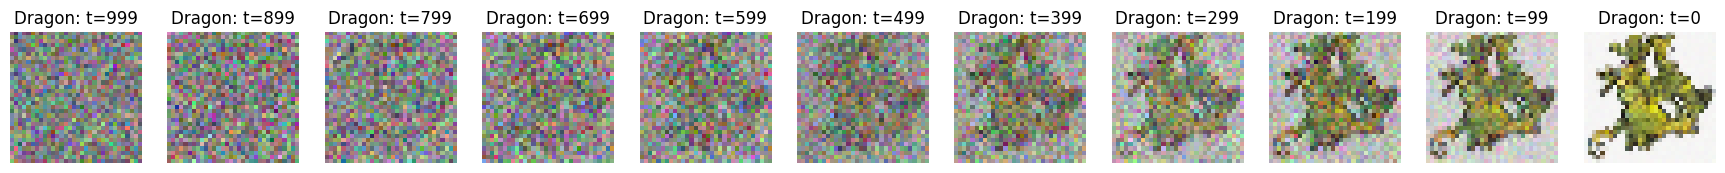

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.1852 - loss: 0.1006 - val_loss: 0.0963 - val_mae: 0.1774
Epoch 2301/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1850 - loss: 0.0993 - val_loss: 0.1046 - val_mae: 0.1859
Epoch 2302/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1890 - loss: 0.1027 - val_loss: 0.1022 - val_mae: 0.1838
Epoch 2303/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1823 - loss: 0.0982 - val_loss: 0.1017 - val_mae: 0.1831
Epoch 2304/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1892 - loss: 0.1044 - val_loss: 0.1085 - val_mae: 0.1832
Epoch 2305/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1803 - loss: 0.0948 - val_loss: 0.0905 - val_mae: 0.1685
Epoch 2306/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1830 - loss: 0.0982 - val_loss: 0.0843 - val_mae: 0.1695
Epoch 2307/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1818 - loss: 0.0981 - val_loss: 0.0999 - val_mae: 0.1836
Epoch 2308/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.82it/s]


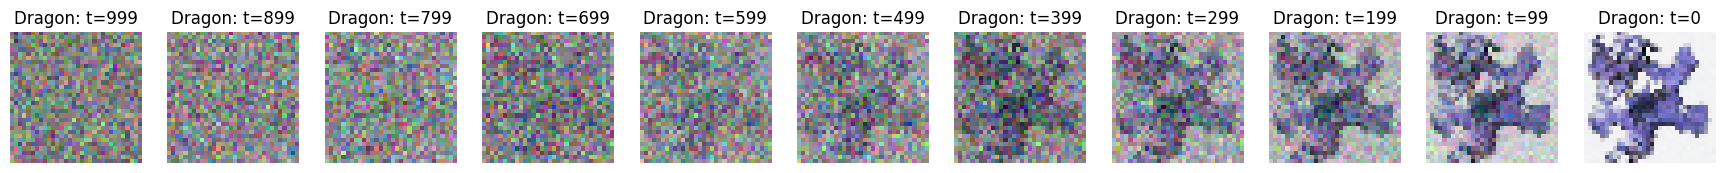

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.1835 - loss: 0.0985 - val_loss: 0.0994 - val_mae: 0.1845
Epoch 2401/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1845 - loss: 0.1000 - val_loss: 0.1022 - val_mae: 0.1924
Epoch 2402/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1822 - loss: 0.0979 - val_loss: 0.0940 - val_mae: 0.1776
Epoch 2403/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1811 - loss: 0.0971 - val_loss: 0.1019 - val_mae: 0.1847
Epoch 2404/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1853 - loss: 0.1006 - val_loss: 0.0851 - val_mae: 0.1716
Epoch 2405/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1842 - loss: 0.0991 - val_loss: 0.1049 - val_mae: 0.1897
Epoch 2406/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1823 - loss: 0.0982 - val_loss: 0.0970 - val_mae: 0.1775
Epoch 2407/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1848 - loss: 0.1008 - val_loss: 0.1085 - val_mae: 0.1895
Epoch 2408/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.84it/s]


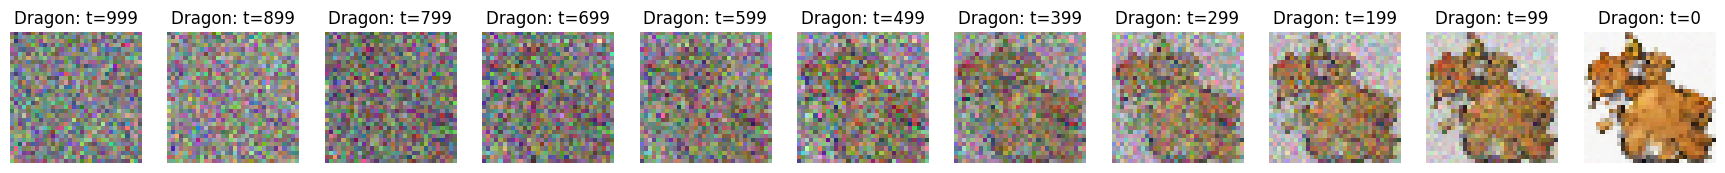

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.1821 - loss: 0.0978 - val_loss: 0.1040 - val_mae: 0.1837
Epoch 2501/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1853 - loss: 0.1007 - val_loss: 0.0972 - val_mae: 0.1838
Epoch 2502/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1841 - loss: 0.0993 - val_loss: 0.1085 - val_mae: 0.1953
Epoch 2503/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1820 - loss: 0.0978 - val_loss: 0.0943 - val_mae: 0.1811
Epoch 2504/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1854 - loss: 0.1028 - val_loss: 0.0805 - val_mae: 0.1668
Epoch 2505/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1788 - loss: 0.0937 - val_loss: 0.1038 - val_mae: 0.1897
Epoch 2506/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1825 - loss: 0.0983 - val_loss: 0.1192 - val_mae: 0.1988
Epoch 2507/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1837 - loss: 0.0984 - val_loss: 0.0943 - val_mae: 0.1755
Epoch 2508/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:31<00:00, 10.92it/s]


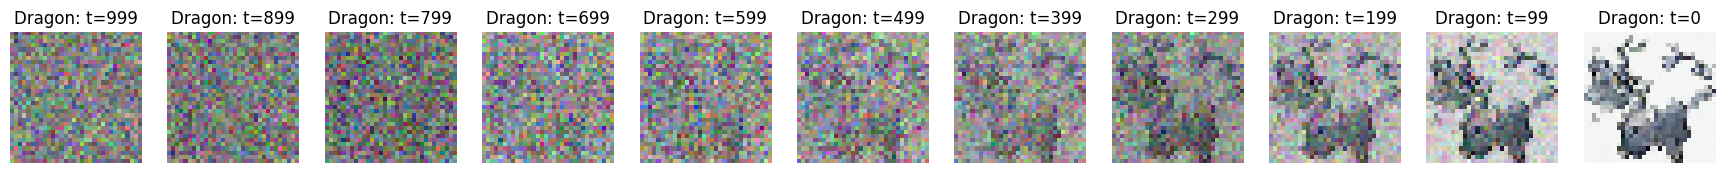

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.1838 - loss: 0.0999 - val_loss: 0.0941 - val_mae: 0.1759
Epoch 2601/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1828 - loss: 0.0989 - val_loss: 0.0988 - val_mae: 0.1814
Epoch 2602/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1851 - loss: 0.1001 - val_loss: 0.1051 - val_mae: 0.1811
Epoch 2603/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1781 - loss: 0.0932 - val_loss: 0.1065 - val_mae: 0.1913
Epoch 2604/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1825 - loss: 0.0984 - val_loss: 0.1116 - val_mae: 0.1947
Epoch 2605/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1848 - loss: 0.1012 - val_loss: 0.1089 - val_mae: 0.1907
Epoch 2606/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1809 - loss: 0.0963 - val_loss: 0.0977 - val_mae: 0.1816
Epoch 2607/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1796 - loss: 0.0951 - val_loss: 0.0893 - val_mae: 0.1745
Epoch 2608/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.80it/s]


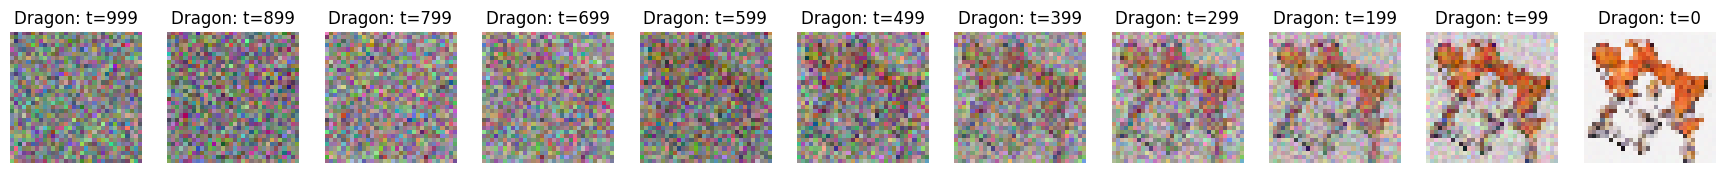

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.1800 - loss: 0.0963 - val_loss: 0.0830 - val_mae: 0.1678
Epoch 2701/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - mae: 0.1838 - loss: 0.0999 - val_loss: 0.1018 - val_mae: 0.1823
Epoch 2702/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1819 - loss: 0.0974 - val_loss: 0.1104 - val_mae: 0.1939
Epoch 2703/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1795 - loss: 0.0950 - val_loss: 0.0967 - val_mae: 0.1808
Epoch 2704/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1807 - loss: 0.0964 - val_loss: 0.0933 - val_mae: 0.1724
Epoch 2705/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1803 - loss: 0.0963 - val_loss: 0.0845 - val_mae: 0.1677
Epoch 2706/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1775 - loss: 0.0936 - val_loss: 0.0996 - val_mae: 0.1771
Epoch 2707/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1843 - loss: 0.1002 - val_loss: 0.0922 - val_mae: 0.1718
Epoch 2708/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:31<00:00, 10.98it/s]


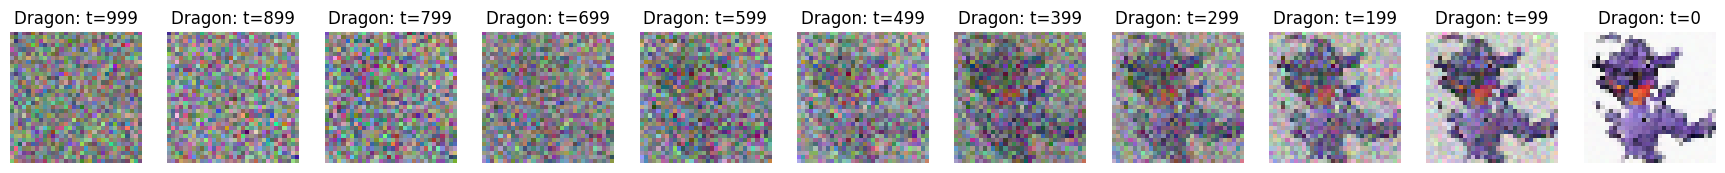

30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - mae: 0.1805 - loss: 0.0958 - val_loss: 0.0975 - val_mae: 0.1822
Epoch 2801/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1779 - loss: 0.0940 - val_loss: 0.1118 - val_mae: 0.1912
Epoch 2802/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1779 - loss: 0.0942 - val_loss: 0.0900 - val_mae: 0.1676
Epoch 2803/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1817 - loss: 0.0979 - val_loss: 0.1047 - val_mae: 0.1842
Epoch 2804/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1809 - loss: 0.0965 - val_loss: 0.1043 - val_mae: 0.1891
Epoch 2805/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1785 - loss: 0.0942 - val_loss: 0.1034 - val_mae: 0.1841
Epoch 2806/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1831 - loss: 0.0988 - val_loss: 0.0915 - val_mae: 0.1750
Epoch 2807/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1798 - loss: 0.0954 - val_loss: 0.0952 - val_mae: 0.1777
Epoch 2808/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.83it/s]


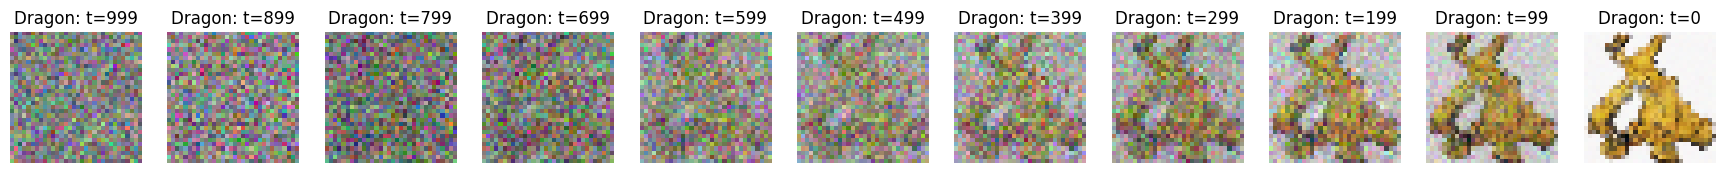

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.1807 - loss: 0.0957 - val_loss: 0.1009 - val_mae: 0.1834
Epoch 2901/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1816 - loss: 0.0969 - val_loss: 0.0961 - val_mae: 0.1789
Epoch 2902/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1827 - loss: 0.0999 - val_loss: 0.0915 - val_mae: 0.1748
Epoch 2903/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1787 - loss: 0.0956 - val_loss: 0.0998 - val_mae: 0.1808
Epoch 2904/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1801 - loss: 0.0968 - val_loss: 0.1052 - val_mae: 0.1903
Epoch 2905/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1791 - loss: 0.0955 - val_loss: 0.1008 - val_mae: 0.1860
Epoch 2906/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1785 - loss: 0.0950 - val_loss: 0.1174 - val_mae: 0.1966
Epoch 2907/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1811 - loss: 0.0965 - val_loss: 0.0983 - val_mae: 0.1800
Epoch 2908/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.55it/s]


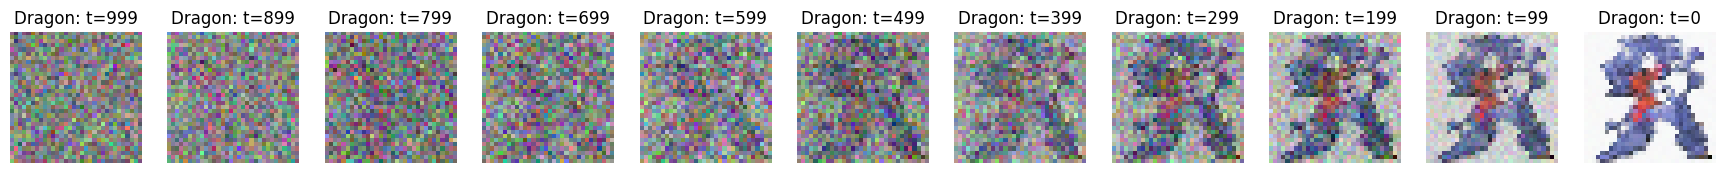

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1785 - loss: 0.0959 - val_loss: 0.1066 - val_mae: 0.1873
Epoch 3001/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1810 - loss: 0.0975 - val_loss: 0.1000 - val_mae: 0.1826
Epoch 3002/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1767 - loss: 0.0930 - val_loss: 0.0968 - val_mae: 0.1781
Epoch 3003/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1798 - loss: 0.0964 - val_loss: 0.1092 - val_mae: 0.1871
Epoch 3004/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1787 - loss: 0.0950 - val_loss: 0.1058 - val_mae: 0.1880
Epoch 3005/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1801 - loss: 0.0969 - val_loss: 0.1111 - val_mae: 0.1929
Epoch 3006/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1799 - loss: 0.0964 - val_loss: 0.0931 - val_mae: 0.1756
Epoch 3007/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1799 - loss: 0.0954 - val_loss: 0.0996 - val_mae: 0.1834
Epoch 3008/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.54it/s]


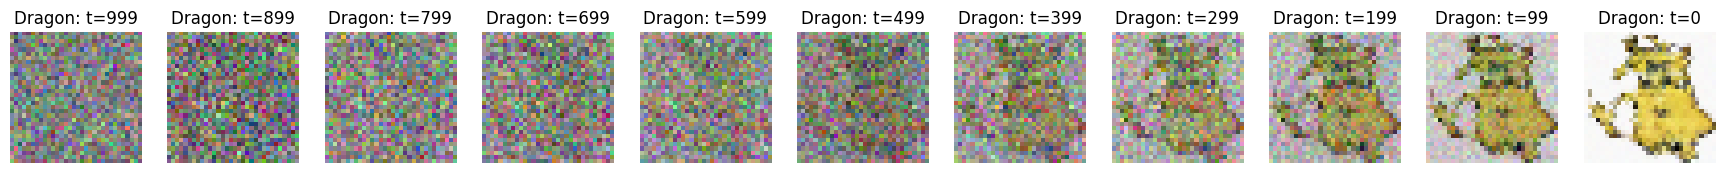

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1815 - loss: 0.0988 - val_loss: 0.1236 - val_mae: 0.1981
Epoch 3101/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - mae: 0.1791 - loss: 0.0956 - val_loss: 0.1061 - val_mae: 0.1874
Epoch 3102/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1794 - loss: 0.0964 - val_loss: 0.1156 - val_mae: 0.1963
Epoch 3103/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1792 - loss: 0.0962 - val_loss: 0.0910 - val_mae: 0.1689
Epoch 3104/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1799 - loss: 0.0954 - val_loss: 0.0998 - val_mae: 0.1818
Epoch 3105/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1795 - loss: 0.0967 - val_loss: 0.1024 - val_mae: 0.1866
Epoch 3106/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1821 - loss: 0.0979 - val_loss: 0.1095 - val_mae: 0.1912
Epoch 3107/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1811 - loss: 0.0981 - val_loss: 0.0948 - val_mae: 0.1781
Epoch 3108/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.52it/s]


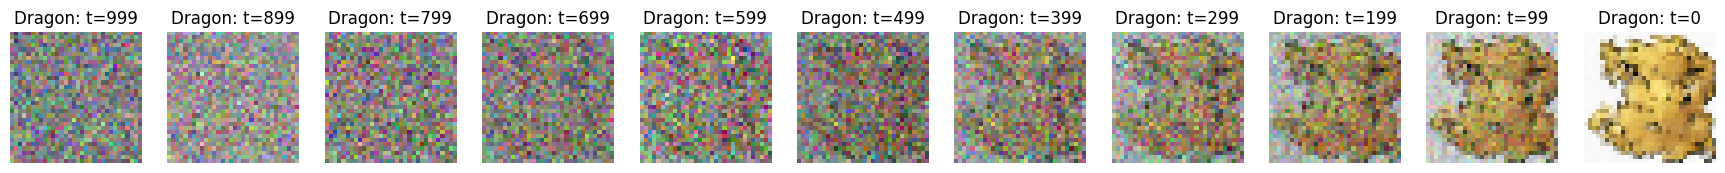

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1811 - loss: 0.0976 - val_loss: 0.1017 - val_mae: 0.1852
Epoch 3201/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1770 - loss: 0.0950 - val_loss: 0.1016 - val_mae: 0.1788
Epoch 3202/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1798 - loss: 0.0962 - val_loss: 0.1044 - val_mae: 0.1860
Epoch 3203/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1783 - loss: 0.0944 - val_loss: 0.1033 - val_mae: 0.1865
Epoch 3204/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1765 - loss: 0.0935 - val_loss: 0.0935 - val_mae: 0.1754
Epoch 3205/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1763 - loss: 0.0935 - val_loss: 0.1028 - val_mae: 0.1901
Epoch 3206/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1785 - loss: 0.0960 - val_loss: 0.0964 - val_mae: 0.1752
Epoch 3207/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1796 - loss: 0.0959 - val_loss: 0.0893 - val_mae: 0.1713
Epoch 3208/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.57it/s]


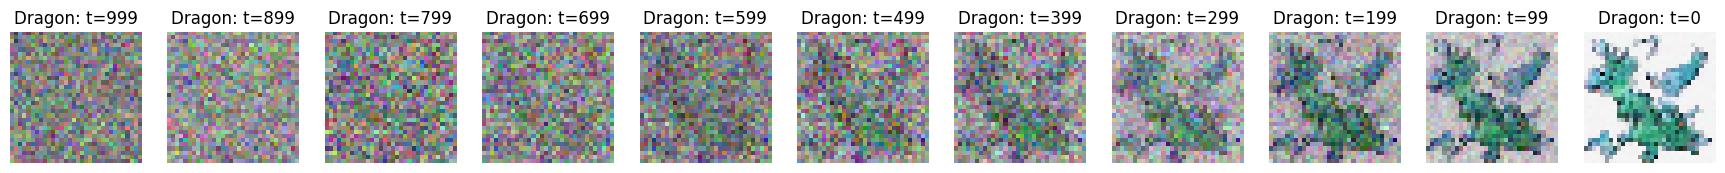

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1759 - loss: 0.0927 - val_loss: 0.0944 - val_mae: 0.1739
Epoch 3301/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1734 - loss: 0.0907 - val_loss: 0.0994 - val_mae: 0.1824
Epoch 3302/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1807 - loss: 0.0978 - val_loss: 0.1068 - val_mae: 0.1913
Epoch 3303/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1796 - loss: 0.0968 - val_loss: 0.0873 - val_mae: 0.1680
Epoch 3304/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1768 - loss: 0.0938 - val_loss: 0.0977 - val_mae: 0.1826
Epoch 3305/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1823 - loss: 0.0987 - val_loss: 0.0938 - val_mae: 0.1800
Epoch 3306/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1788 - loss: 0.0960 - val_loss: 0.1050 - val_mae: 0.1818
Epoch 3307/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1750 - loss: 0.0923 - val_loss: 0.1027 - val_mae: 0.1850
Epoch 3308/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.56it/s]


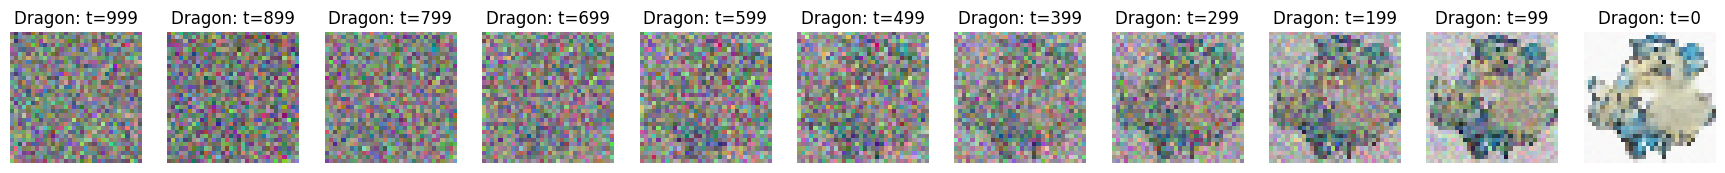

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1789 - loss: 0.0961 - val_loss: 0.0845 - val_mae: 0.1688
Epoch 3401/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1820 - loss: 0.0985 - val_loss: 0.0750 - val_mae: 0.1548
Epoch 3402/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1789 - loss: 0.0966 - val_loss: 0.0927 - val_mae: 0.1754
Epoch 3403/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1787 - loss: 0.0958 - val_loss: 0.0964 - val_mae: 0.1766
Epoch 3404/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1745 - loss: 0.0914 - val_loss: 0.1000 - val_mae: 0.1761
Epoch 3405/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1770 - loss: 0.0940 - val_loss: 0.1008 - val_mae: 0.1827
Epoch 3406/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1756 - loss: 0.0922 - val_loss: 0.0891 - val_mae: 0.1693
Epoch 3407/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - mae: 0.1774 - loss: 0.0943 - val_loss: 0.1132 - val_mae: 0.1925
Epoch 3408/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:33<00:00, 10.63it/s]


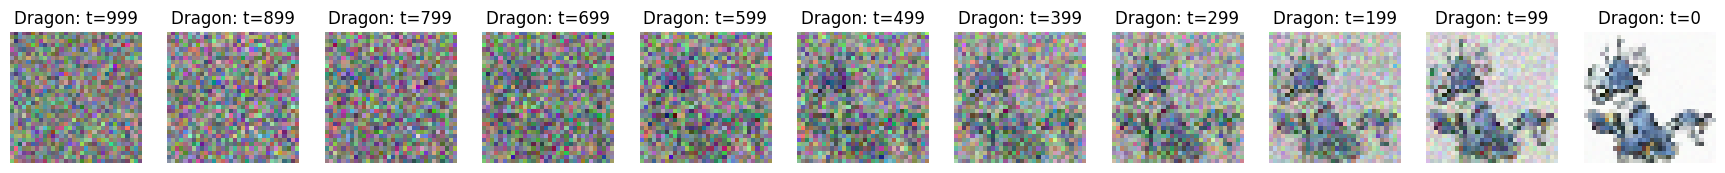

30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - mae: 0.1775 - loss: 0.0945 - val_loss: 0.1031 - val_mae: 0.1837
Epoch 3501/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1740 - loss: 0.0921 - val_loss: 0.1121 - val_mae: 0.1909
Epoch 3502/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1760 - loss: 0.0940 - val_loss: 0.0927 - val_mae: 0.1789
Epoch 3503/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1751 - loss: 0.0922 - val_loss: 0.1023 - val_mae: 0.1838
Epoch 3504/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1787 - loss: 0.0963 - val_loss: 0.1012 - val_mae: 0.1863
Epoch 3505/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1773 - loss: 0.0945 - val_loss: 0.0956 - val_mae: 0.1793
Epoch 3506/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - mae: 0.1736 - loss: 0.0912 - val_loss: 0.0994 - val_mae: 0.1797
Epoch 3507/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1753 - loss: 0.0931 - val_loss: 0.0868 - val_mae: 0.1713
Epoch 3508/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.59it/s]


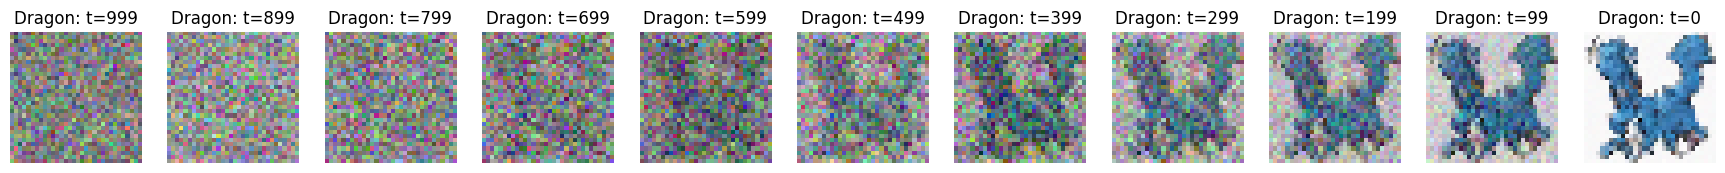

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1760 - loss: 0.0935 - val_loss: 0.0957 - val_mae: 0.1750
Epoch 3601/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1768 - loss: 0.0944 - val_loss: 0.1045 - val_mae: 0.1894
Epoch 3602/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1768 - loss: 0.0938 - val_loss: 0.1095 - val_mae: 0.1875
Epoch 3603/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1720 - loss: 0.0899 - val_loss: 0.0928 - val_mae: 0.1754
Epoch 3604/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1762 - loss: 0.0944 - val_loss: 0.0863 - val_mae: 0.1687
Epoch 3605/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1742 - loss: 0.0925 - val_loss: 0.0875 - val_mae: 0.1733
Epoch 3606/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1774 - loss: 0.0948 - val_loss: 0.1048 - val_mae: 0.1820
Epoch 3607/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - mae: 0.1751 - loss: 0.0920 - val_loss: 0.1091 - val_mae: 0.1911
Epoch 3608/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:32<00:00, 10.76it/s]


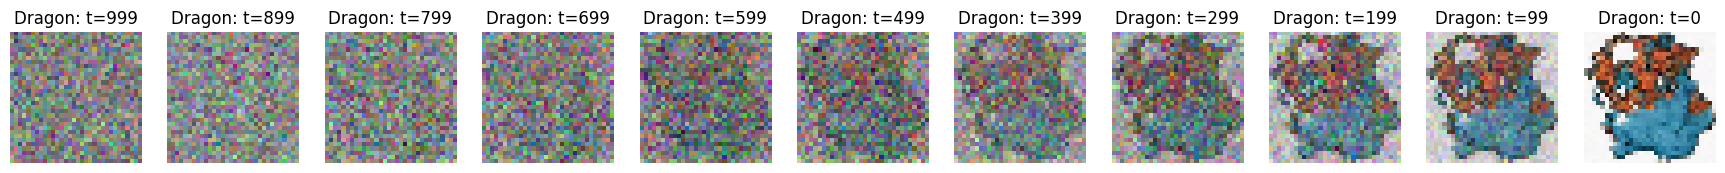

30/30 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - mae: 0.1733 - loss: 0.0912 - val_loss: 0.0962 - val_mae: 0.1754
Epoch 3701/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1785 - loss: 0.0955 - val_loss: 0.0867 - val_mae: 0.1649
Epoch 3702/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1754 - loss: 0.0934 - val_loss: 0.1125 - val_mae: 0.1929
Epoch 3703/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1734 - loss: 0.0914 - val_loss: 0.0945 - val_mae: 0.1798
Epoch 3704/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1739 - loss: 0.0910 - val_loss: 0.0994 - val_mae: 0.1789
Epoch 3705/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1761 - loss: 0.0936 - val_loss: 0.1136 - val_mae: 0.1931
Epoch 3706/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1771 - loss: 0.0941 - val_loss: 0.1017 - val_mae: 0.1825
Epoch 3707/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1752 - loss: 0.0931 - val_loss: 0.1009 - val_mae: 0.1827
Epoch 3708/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.58it/s]


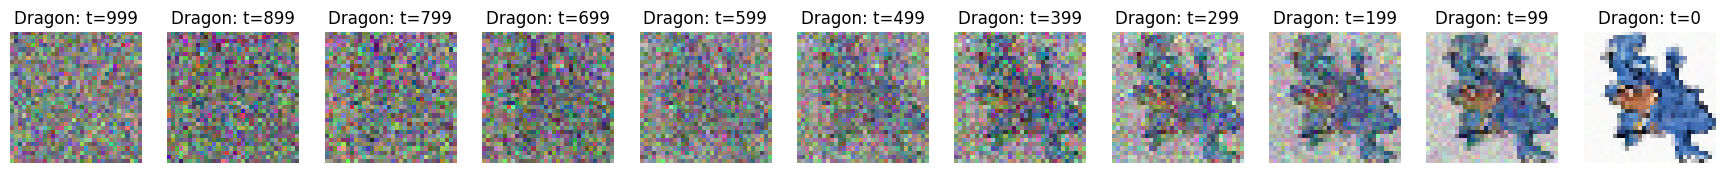

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1789 - loss: 0.0962 - val_loss: 0.1021 - val_mae: 0.1824
Epoch 3801/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1738 - loss: 0.0915 - val_loss: 0.1050 - val_mae: 0.1833
Epoch 3802/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1712 - loss: 0.0892 - val_loss: 0.0899 - val_mae: 0.1756
Epoch 3803/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1726 - loss: 0.0911 - val_loss: 0.0964 - val_mae: 0.1757
Epoch 3804/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1754 - loss: 0.0930 - val_loss: 0.0889 - val_mae: 0.1672
Epoch 3805/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1799 - loss: 0.0974 - val_loss: 0.1116 - val_mae: 0.1943
Epoch 3806/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1740 - loss: 0.0920 - val_loss: 0.0979 - val_mae: 0.1790
Epoch 3807/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1735 - loss: 0.0908 - val_loss: 0.0945 - val_mae: 0.1780
Epoch 3808/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.61it/s]


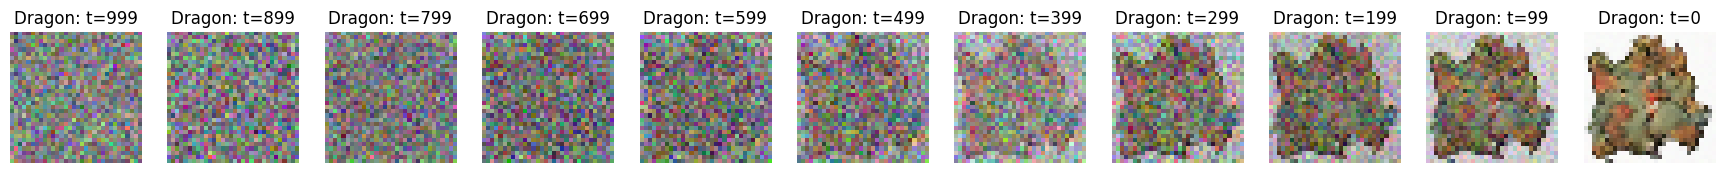

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1718 - loss: 0.0901 - val_loss: 0.1162 - val_mae: 0.1979
Epoch 3901/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1750 - loss: 0.0933 - val_loss: 0.0814 - val_mae: 0.1612
Epoch 3902/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1725 - loss: 0.0901 - val_loss: 0.1190 - val_mae: 0.1990
Epoch 3903/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1735 - loss: 0.0912 - val_loss: 0.0882 - val_mae: 0.1710
Epoch 3904/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1746 - loss: 0.0923 - val_loss: 0.1065 - val_mae: 0.1893
Epoch 3905/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - mae: 0.1746 - loss: 0.0923 - val_loss: 0.0912 - val_mae: 0.1744
Epoch 3906/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - mae: 0.1732 - loss: 0.0917 - val_loss: 0.1029 - val_mae: 0.1854
Epoch 3907/4000
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - mae: 0.1760 - loss: 0.0932 - val_loss: 0.0933 - val_mae: 0.1753
Epoch 3908/4000
30/30 ━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:34<00:00, 10.54it/s]


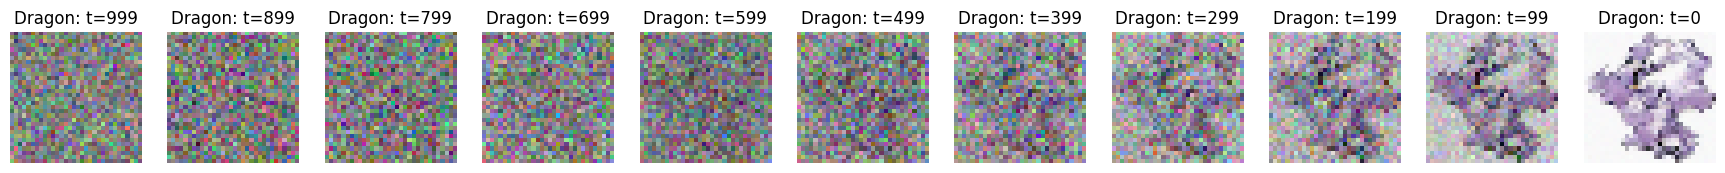

30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - mae: 0.1731 - loss: 0.0911 - val_loss: 0.0986 - val_mae: 0.1783


In [7]:
# Train the model
# =====================================================================
diff_callback = DiffusionCallback(model, 100, "Dragon")
history = model.fit(
    train_poke_dataset,
    epochs=EPOCHS,
    validation_data=test_poke_dataset,
    callbacks=[diff_callback],
)

## 2.2. Evaluación del modelo

Una vez entrenado el modelo, lo evaluamos gracias al conjunto de testeo que definimos anteriormente. Para evaluar el entrenamiento del modelo se mostrarán la evolución de los valores de la función de perdida y las métricas a lo largo del entrenamiento. Todo ello, para garantizar el correcto entrenamiento del modelo de difusión, evitando su overfitting principalmente.

Y tal y como podemos observar el modelo no sufre de overfitting y ambas funciones tienen a minimizar el error cometido correctamente, por lo que podemos garantizar que el entrenamiento se ha realizado con éxito.

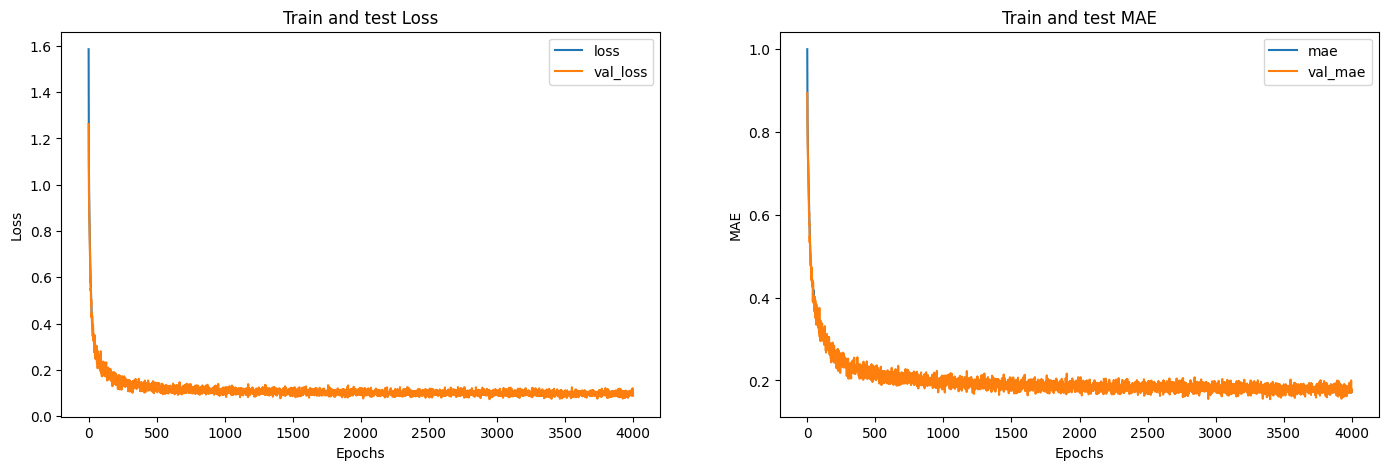

In [8]:
visualize.plot_history(history)

## 2.3. Guardado del modelo

Finalmente, una vez comprobado el correcto entrenamiento del modelo, procedemos a guardarlo para futuras síntesis de imágenes sin necesidad de estar entrenando de nuevo el modelo. Los resultados finales se presentarán en el siguiente notebook.

In [9]:
# Save the model
# =====================================================================
save_path = f"{MODELS_PATH}/final_diffusion_model_{EPOCHS}.weights.h5"
model.save_weights(save_path)

[BACK TO TOP](#top)